In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib
import ast

import os

import sys
sys.path.append("../")
sys.path.append("../..")

from rsna.src.prepare_data import preprocess_dcm_slice
import cv2

import SimpleITK as sitk
from concurrent.futures import ThreadPoolExecutor
from collections import Counter


import plotly.graph_objects as go

In [3]:
traindf = pd.read_csv("../data/train.csv")
labeldf = pd.read_csv("../data/train_localizers.csv")

In [4]:
i = 0

In [5]:
sidx = i
for i in range(sidx+1, traindf.shape[0]):
    idx = i
    uid = traindf.iloc[idx, 0]
    niipath = f"../data/segmentations/{uid}_cowseg.nii"
    if os.path.exists(niipath):
        label = nib.load(niipath)
        print(i)
        break


13


In [6]:

label.get_fdata().shape # NOTE: SHAPE is x,y,z

(512, 512, 228)

In [7]:
traindf[traindf["SeriesInstanceUID"] == uid]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
13,1.2.826.0.1.3680043.8.498.10035643165968342618...,62,Female,CTA,0,0,0,1,1,0,0,0,1,0,0,0,0,1


In [8]:
labels = [
    "BG",
"Other Posterior Circulation",
"Basilar Tip",
"R Posterior Communicating Artery",
"L Posterior Communicating Artery",
"R Infraclinoid Internal Carotid Artery",
"L Infraclinoid Internal Carotid Artery",
"R Supraclinoid Internal Carotid Artery",
"L Supraclinoid Internal Carotid Artery",
"R Middle Cerebral Artery",
"L Middle Cerebral Artery",
"R Anterior Cerebral Artery",
"L Anterior Cerebral Artery",
"Anterior Communicating Artery"

]

In [10]:
def get_label_coords(uid):
    
    l = ast.literal_eval(labeldf[labeldf["SeriesInstanceUID"] == uid].coordinates.iloc[0])
    suid = labeldf[labeldf["SeriesInstanceUID"] == uid].SOPInstanceUID.iloc[0]

    ds = pydicom.dcmread(f"../data/series/{uid}/{suid}.dcm")
    
    return int(l["x"]),int(l["y"]), int(ds.InstanceNumber)


def view_nii_segmentation_interactive(uid, file_path: str):
    """
    Loads and creates an INTERACTIVE 3D view of a .nii segmentation.

    This function uses Plotly for an interactive experience, allowing you to
    rotate, zoom, and inspect the segmented structures in a web browser.

    Args:
        file_path (str): The full path to the .nii or .nii.gz file.
    """
    nii_image = nib.load(file_path)
    data = nii_image.get_fdata()

    print(f"Image dimensions: {data.shape}")
    unique_labels = np.unique(data)
    print(f"Found labels: {unique_labels}")
    
    # Create a Plotly figure
    fig = go.Figure()
    # fig = go.FigureWidget()

    # Add a trace for each segmented label
    for label_value in unique_labels:
        if label_value == 0:  # Skip background
            continue
        
        x, y, z = np.where(data == label_value)
        
        fig.add_trace(go.Scatter3d(
            x=x, y=data.shape[1] - y, z=z,
            mode='markers',
            marker=dict(size=2, opacity=0.9),
            name=f'{labels[int(label_value)]}'
        ))

    lx,ly,lz =  get_label_coords(uid)
    fig.add_trace(
        go.Scatter3d(
            x=[lx],y=[ly],z=[lz],
            mode='markers',
            marker=dict(size=5, opacity=0.9),
            name='Label'
        )
    )

    # Update the layout for a clean look
    fig.update_layout(
        title_text='Interactive 3D Brain Artery Segmentation 🧠',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis',
            aspectratio=dict(x=1, y=1, z=1),
            aspectmode='data'  # Ensures correct proportions
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    return fig.show()

# --- How to use the function ---
# Replace this path with the actual path to your .nii file
# your_file_path = '/path/to/your/brain_cta_segmentation.nii.gz'
# view_nii_segmentation_interactive(your_file_path)

In [11]:
get_label_coords(uid)

(223, 225, 75)

In [12]:
view_nii_segmentation_interactive(uid,niipath)

Image dimensions: (512, 512, 228)
Found labels: [ 0.  1.  2.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [13]:
suid = labeldf[labeldf["SeriesInstanceUID"] == uid].iloc[0,1]
ds = pydicom.dcmread(f"../data/series/{uid}/{suid}.dcm")
x,y,z = get_label_coords(uid)

(512, 512)


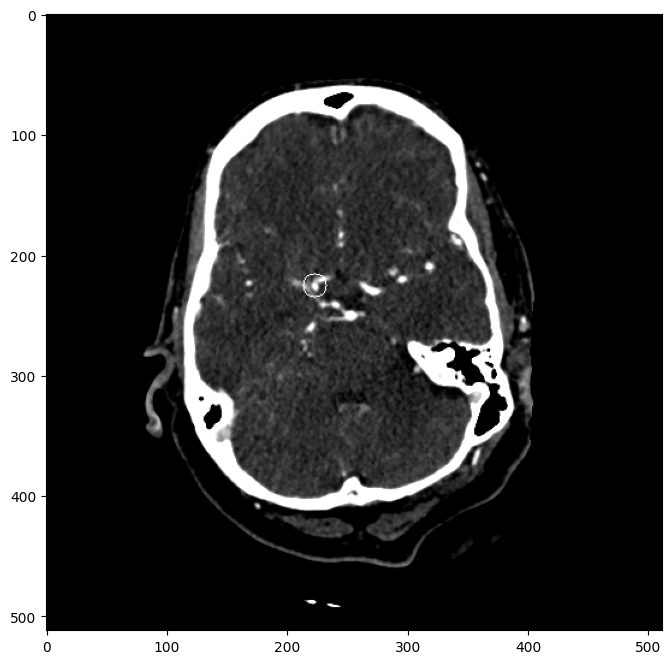

In [14]:
img = preprocess_dcm_slice(ds.pixel_array,ds, ds.pixel_array.T.shape)
print(img.shape)
img = cv2.circle(img, (x,y), 10, (255,0,0), 1)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray")